In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers[torch] datasets accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.wh

In [ ]:
import pandas as pd
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
import torch
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/CZ4034/train_labeled_lyrics_english.csv')
train_df = train_df.iloc[:, 1:]
train_df

,Unnamed: 0,artist,album,track,track_id,lyrics,duration,genre,emotion,intensity
0,18924,Linkin Park,LIVING THINGS: Acapellas and Instrumentals,SKIN TO BONE - Acapella,0jw00DFjpx3AjcPtVCS1st,"Skin to bone, steel to rust\nAsh to ashes, dus...",2 minutes 37 seconds,"['alternative metal', 'nu metal', 'post-grunge...",acceptance,low
1,22125,Ava Max,So Am I (The Remixes),So Am I - Toby Green Remix,26c18xZN2XSjK50hoYWQrz,Do you ever feel like a misfit?\nEverything in...,2 minutes 46 seconds,['pop'],acceptance,low
2,3717,Benson Boone,Hits 2024,Crazy,3lJkIVh6lYW0pERAtwu4kJ,Something don't feel right\nYou got a way with...,3 minutes 7 seconds,['singer-songwriter pop'],acceptance,low
3,12691,Billie Eilish,Sunset Vibes,Clown,6FAfVzdBlNrvks8hiOokCl,I guess it's funnier from where you're standin...,3 minutes 41 seconds,"['art pop', 'pop']",acceptance,low
4,13966,Lana Del Rey,Lust For Life,Get Free,761QvVHTibYjEi2r6A4g4Q,"Finally, I'm crossing the threshold\nFrom the ...",5 minutes 34 seconds,"['art pop', 'pop']",acceptance,low
...,...,...,...,...,...,...,...,...,...,...
1079,9179,Black Sabbath,The Eternal Idol (Deluxe Edition),The Shining (2009 Remaster),1lSUiRmzS2c1KGrZqaeMWV,There's a man who sees all there is to see\nWh...,5 minutes 58 seconds,"['album rock', 'alternative metal', 'birmingha...",vigilance,high
1080,22976,Slayer,Show No Mercy,Fight Till Death,5xFqDS7kANSCyzne6yqjIV,Metal and men clash once more to the end\nWarr...,3 minutes 37 seconds,"['alternative metal', 'death metal', 'groove m...",vigilance,high
1081,22627,Keshi,Sex Music 2022,First,6YY1WmsYGgTAwFWab6jHAY,Promise that you won't kiss and tell\nI'm for ...,3 minutes 26 seconds,['chill r&b'],vigilance,high
1082,16555,Elton John,Blue Moves,If There's A God In Heaven (What's He Waiting ...,0jfP8jD5xZBWXUJ0H36UKz,"Torn from their families, mothers go hungry\nT...",4 minutes 25 seconds,"['glam rock', 'mellow gold', 'piano rock', 'ro...",vigilance,high


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = 32
id2label = {
    "0": "serenity",
    "1": "joy",
    "2": "ecstasy",
    "3": "love",
    "4": "acceptance",
    "5": "trust",
    "6": "admiration",
    "7": "submission",
    "8": "apprehension",
    "9": "fear",
    "10": "terror",
    "11": "awe",
    "12": "distraction",
    "13": "surprise",
    "14": "amazement",
    "15": "disapproval",
    "16": "pensiveness",
    "17": "sadness",
    "18": "grief",
    "19": "remorse",
    "20": "boredom",
    "21": "disgust",
    "22": "loathing",
    "23": "contempt",
    "24": "annoyance",
    "25": "anger",
    "26": "rage",
    "27": "aggressiveness",
    "28": "interest",
    "29": "anticipation",
    "30": "vigilance",
    "31": "optimism"

}

label2id = {
    "serenity": 0,
    "joy": 1,
    "ecstasy": 2,
    "love": 3,
    "acceptance": 4,
    "trust": 5,
    "admiration": 6,
    "submission": 7,
    "apprehension": 8,
    "fear": 9,
    "terror": 10,
    "awe": 11,
    "distraction": 12,
    "surprise": 13,
    "amazement": 14,
    "disapproval": 15,
    "pensiveness": 16,
    "sadness": 17,
    "grief": 18,
    "remorse": 19,
    "boredom": 20,
    "disgust": 21,
    "loathing": 22,
    "contempt": 23,
    "annoyance": 24,
    "anger": 25,
    "rage": 26,
    "aggressiveness": 27,
    "interest": 28,
    "anticipation": 29,
    "vigilance": 30,
    "optimism": 31
}


In [ ]:
train_df["label"] = train_df["emotion"].apply(lambda x: label2id[x])
train_df

,Unnamed: 0,artist,album,track,track_id,lyrics,duration,genre,emotion,intensity,label
0,18924,Linkin Park,LIVING THINGS: Acapellas and Instrumentals,SKIN TO BONE - Acapella,0jw00DFjpx3AjcPtVCS1st,"Skin to bone, steel to rust\nAsh to ashes, dus...",2 minutes 37 seconds,"['alternative metal', 'nu metal', 'post-grunge...",acceptance,low,4
1,22125,Ava Max,So Am I (The Remixes),So Am I - Toby Green Remix,26c18xZN2XSjK50hoYWQrz,Do you ever feel like a misfit?\nEverything in...,2 minutes 46 seconds,['pop'],acceptance,low,4
2,3717,Benson Boone,Hits 2024,Crazy,3lJkIVh6lYW0pERAtwu4kJ,Something don't feel right\nYou got a way with...,3 minutes 7 seconds,['singer-songwriter pop'],acceptance,low,4
3,12691,Billie Eilish,Sunset Vibes,Clown,6FAfVzdBlNrvks8hiOokCl,I guess it's funnier from where you're standin...,3 minutes 41 seconds,"['art pop', 'pop']",acceptance,low,4
4,13966,Lana Del Rey,Lust For Life,Get Free,761QvVHTibYjEi2r6A4g4Q,"Finally, I'm crossing the threshold\nFrom the ...",5 minutes 34 seconds,"['art pop', 'pop']",acceptance,low,4
...,...,...,...,...,...,...,...,...,...,...,...
1079,9179,Black Sabbath,The Eternal Idol (Deluxe Edition),The Shining (2009 Remaster),1lSUiRmzS2c1KGrZqaeMWV,There's a man who sees all there is to see\nWh...,5 minutes 58 seconds,"['album rock', 'alternative metal', 'birmingha...",vigilance,high,30
1080,22976,Slayer,Show No Mercy,Fight Till Death,5xFqDS7kANSCyzne6yqjIV,Metal and men clash once more to the end\nWarr...,3 minutes 37 seconds,"['alternative metal', 'death metal', 'groove m...",vigilance,high,30
1081,22627,Keshi,Sex Music 2022,First,6YY1WmsYGgTAwFWab6jHAY,Promise that you won't kiss and tell\nI'm for ...,3 minutes 26 seconds,['chill r&b'],vigilance,high,30
1082,16555,Elton John,Blue Moves,If There's A God In Heaven (What's He Waiting ...,0jfP8jD5xZBWXUJ0H36UKz,"Torn from their families, mothers go hungry\nT...",4 minutes 25 seconds,"['glam rock', 'mellow gold', 'piano rock', 'ro...",vigilance,high,30


# **OVERSAMPLING**

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler

In [ ]:
x = train_df.iloc[:, 5] # lyrics column
y = train_df.iloc[:, 10] # label column
print(len(x), len(y))
print(x)
print(y)

1084 1084
0       Skin to bone, steel to rust\nAsh to ashes, dus...
1       Do you ever feel like a misfit?\nEverything in...
2       Something don't feel right\nYou got a way with...
3       I guess it's funnier from where you're standin...
4       Finally, I'm crossing the threshold\nFrom the ...
                              ...                        
1079    There's a man who sees all there is to see\nWh...
1080    Metal and men clash once more to the end\nWarr...
1081    Promise that you won't kiss and tell\nI'm for ...
1082    Torn from their families, mothers go hungry\nT...
1083    No regret for the confidence betrayed\nNo more...
Name: lyrics, Length: 1084, dtype: object
0        4
1        4
2        4
3        4
4        4
        ..
1079    30
1080    30
1081    30
1082    30
1083    30
Name: label, Length: 1084, dtype: int64


In [ ]:
type(x), len(x), x[0]

(pandas.core.series.Series,
 1084,
 "Skin to bone, steel to rust\nAsh to ashes, dust to dust\nLet tomorrow have its way\nWith the promises we made\nSkin to bone, steel to rust\n♪\nAsh to ashes, dust to dust\nYour deception, my disgust\nWhen your name is finally drawn\nI'll be happy that you're gone\nAsh to ashes, dust to dust\nAh-ah-ah-ah-ah-ah\nAsh to ashes, dust to dust\nAh-ah-ah-ah-ah-ah\nSkin to bone and steel to rust\nRight to left left to right\nNight to day and day to night\nAs the starlight fades to gray\nI'll be marching far away\nRight to left and left to right\nAh-ah-ah-ah-ah-ah\nAsh to ashes, dust to dust\nAh-ah-ah-ah-ah-ah\nSkin to bone and steel to rust\nLet tomorrow have its way\nWith the promises betrayed\nSkin to bone and steel to rust\nSkin to bone and steel to rust\nSkin to bone and steel to rust\n")

In [ ]:
type(y), len(y), y

(pandas.core.series.Series,
 1084,
 0        4
 1        4
 2        4
 3        4
 4        4
         ..
 1079    30
 1080    30
 1081    30
 1082    30
 1083    30
 Name: label, Length: 1084, dtype: int64)

In [ ]:
# x_str:  row index
x_str = np.array(range(len(x))).reshape(-1, 1)
len(x_str), x_str

(1084,
 array([[   0],
        [   1],
        [   2],
        ...,
        [1081],
        [1082],
        [1083]]))

In [ ]:
print('Original dataset shape %s' % Counter(y))
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(x_str, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({2: 139, 1: 117, 27: 93, 18: 76, 3: 56, 24: 52, 29: 51, 22: 51, 17: 49, 16: 48, 25: 37, 31: 37, 6: 34, 8: 33, 9: 30, 26: 27, 21: 26, 19: 23, 10: 17, 30: 15, 5: 14, 28: 10, 7: 10, 0: 9, 11: 8, 23: 8, 4: 5, 15: 4, 20: 2, 13: 2, 12: 1})
Resampled dataset shape Counter({4: 139, 6: 139, 27: 139, 25: 139, 24: 139, 29: 139, 8: 139, 11: 139, 20: 139, 23: 139, 15: 139, 21: 139, 12: 139, 2: 139, 9: 139, 18: 139, 28: 139, 1: 139, 22: 139, 3: 139, 31: 139, 16: 139, 26: 139, 19: 139, 17: 139, 0: 139, 7: 139, 13: 139, 10: 139, 5: 139, 30: 139})


# There is no songs labeled with 'amazement'

In [ ]:
print(f"{list(set(range(31)) - set(Counter(y_res).keys()))} is not in the resampled dataset")

[14] is not in the resampled dataset


In [ ]:
# convert resampled row indexes back into lyrics
X_res = [x[i] for i in X_res.flatten()]

In [ ]:
resampled_df = pd.DataFrame(X_res, columns=['lyrics'])
resampled_df['label'] = y_res
resampled_df['emotion'] = [id2label[str(y)] for y in y_res]
# resampled_df['intensity'] = [intensity[id2intensity[str(y)]] for y in y_res]
resampled_df

,lyrics,label,emotion
0,"Skin to bone, steel to rust\nAsh to ashes, dus...",4,acceptance
1,Do you ever feel like a misfit?\nEverything in...,4,acceptance
2,Something don't feel right\nYou got a way with...,4,acceptance
3,I guess it's funnier from where you're standin...,4,acceptance
4,"Finally, I'm crossing the threshold\nFrom the ...",4,acceptance
...,...,...,...
4304,I love it when you just don't care\nI love it ...,31,optimism
4305,It's an illusion\nThere's too much confusion\n...,31,optimism
4306,"Under my skin, beneath my fingertips\nYou slip...",31,optimism
4307,Came in from a rainy Thursday on the avenue\nT...,31,optimism


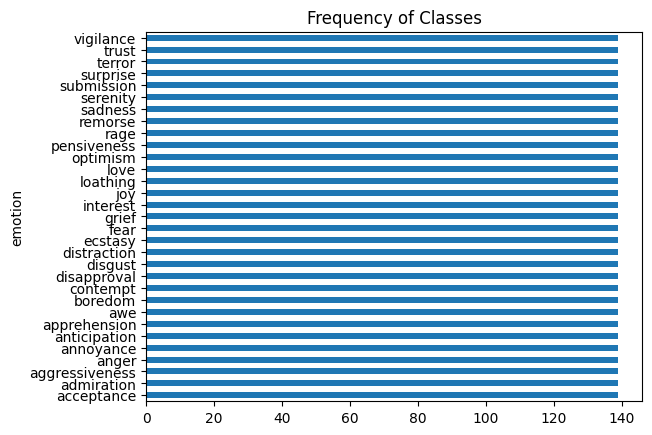

In [ ]:
resampled_df["emotion"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

# **Fine-tuning BERT**

In [ ]:
model_name = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

def tokenize(batch):
    return tokenizer(batch["lyrics"], padding=True, truncation=True, max_length=512)

In [ ]:
eval_df = pd.read_csv('/content/drive/MyDrive/CZ4034/eval_labeled_lyrics.csv')
len(eval_df), eval_df.columns

(1102,
 Index(['Unnamed: 0', 'artist', 'album', 'track', 'track_id', 'lyrics',
        'duration', 'genre', 'emotion', 'intensity'],
       dtype='object'))

In [ ]:
resampled_dataset = Dataset.from_pandas(resampled_df)
resampled_dataset

Dataset({
    features: ['lyrics', 'label', 'emotion'],
    num_rows: 4309
})

In [ ]:
eval_df["label"] = eval_df["emotion"].apply(lambda x: label2id[x])
eval_dataset = Dataset.from_pandas(eval_df)
eval_dataset

Dataset({
    features: ['Unnamed: 0', 'artist', 'album', 'track', 'track_id', 'lyrics', 'duration', 'genre', 'emotion', 'intensity', 'label'],
    num_rows: 1102
})

In [ ]:
resampled_encoded = resampled_dataset.map(tokenize, batched=True)
eval_encoded = eval_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/4309 [00:00<?, ? examples/s]

Map:   0%|          | 0/1102 [00:00<?, ? examples/s]

In [ ]:
resampled_encoded, eval_encoded

(Dataset({
     features: ['lyrics', 'label', 'emotion', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 4309
 }),
 Dataset({
     features: ['Unnamed: 0', 'artist', 'album', 'track', 'track_id', 'lyrics', 'duration', 'genre', 'emotion', 'intensity', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 1102
 }))

In [ ]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T


,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


In [ ]:
!huggingface-cli login --token HUGGINGFACE_TOKEN
# from huggingface_hub import notebook_login
# notebook_login()

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)
         .to(device))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
batch_size = 16
logging_steps = len(resampled_encoded) // batch_size
new_model = f"emotional-bert"
training_args = TrainingArguments(output_dir=new_model,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.0001,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  load_best_model_at_end=True,
                                  metric_for_best_model='eval_loss',
                                  greater_is_better=False,
                                  log_level="error")

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=resampled_encoded,
                  eval_dataset=eval_encoded,
                  tokenizer=tokenizer,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
                  )
trainer.train();


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.820000,2.782818,0.173321,0.155587,0.225641,0.173321
2,1.408300,2.325414,0.323049,0.323544,0.365089,0.323049
3,0.601700,2.153311,0.376588,0.366892,0.388018,0.376588
4,0.235700,2.232935,0.372051,0.361992,0.372748,0.372051
5,0.086800,2.351717,0.406534,0.387794,0.389658,0.406534
6,0.032800,2.550348,0.406534,0.383090,0.392614,0.406534


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

In [ ]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1712819249.ce3b1bc82a18.581.0:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sherelyn912/emotional-bert/commit/13ca7928a74970e637110363c17d468f9a76ee6e', commit_message='End of training', commit_description='', oid='13ca7928a74970e637110363c17d468f9a76ee6e', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
for e in trainer.state.log_history:
    print(e.keys())

dict_keys(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'grad_norm', 'learning_rate',

# **sherelyn912/emotional-bert** performance

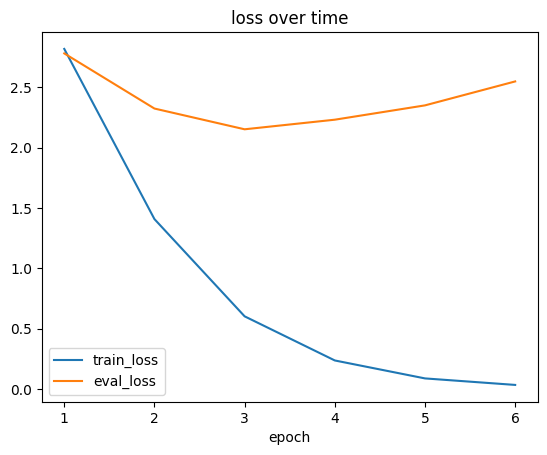

In [ ]:
train = trainer.state.log_history[:-1:2]
eval = trainer.state.log_history[1:-1:2]
train_loss = pd.DataFrame([epoch['loss'] for epoch in train], columns=['train_loss'])
train_loss['epoch'] = range(1, len(train_loss) + 1)
eval_loss = pd.DataFrame([[epoch['eval_loss'],epoch['eval_accuracy'],epoch['eval_f1'],epoch['eval_precision'],epoch['eval_recall']] for epoch in eval], columns=['eval_loss','eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall'])
eval_loss['epoch'] = range(1, len(eval_loss) + 1)
ax = train_loss.plot(x="epoch", y="train_loss")
eval_loss.plot(x="epoch", y="eval_loss", ax=ax)
plt.title("loss over time")
plt.show()

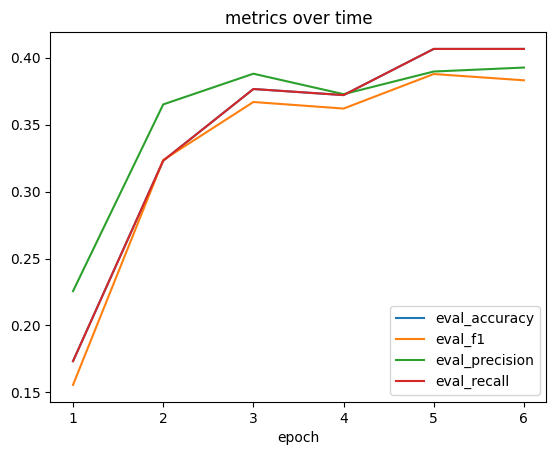

In [ ]:
ax2 = eval_loss.plot(x="epoch", y="eval_accuracy")
eval_loss.plot(x="epoch", y="eval_f1", ax=ax2)
eval_loss.plot(x="epoch", y="eval_precision", ax=ax2)
eval_loss.plot(x="epoch", y="eval_recall", ax=ax2)
plt.title("metrics over time")
plt.show()

# **Fine-tuning GPT-2**

In [ ]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

def tokenize(batch):
    return tokenizer(batch["lyrics"], padding=True, truncation=True, max_length=512)

In [ ]:
eval_df = pd.read_csv('/content/drive/MyDrive/CZ4034/eval_labeled_lyrics.csv')
len(eval_df), eval_df.columns

(1102,
 Index(['Unnamed: 0', 'artist', 'album', 'track', 'track_id', 'lyrics',
        'duration', 'genre', 'emotion', 'intensity'],
       dtype='object'))

In [ ]:
resampled_dataset = Dataset.from_pandas(resampled_df)
resampled_dataset

Dataset({
    features: ['lyrics', 'label', 'emotion'],
    num_rows: 4309
})

In [ ]:
eval_df["label"] = eval_df["emotion"].apply(lambda x: label2id[x])
eval_dataset = Dataset.from_pandas(eval_df)
eval_dataset

Dataset({
    features: ['Unnamed: 0', 'artist', 'album', 'track', 'track_id', 'lyrics', 'duration', 'genre', 'emotion', 'intensity', 'label'],
    num_rows: 1102
})

In [ ]:
resampled_encoded = resampled_dataset.map(tokenize, batched=True)
eval_encoded = eval_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/4309 [00:00<?, ? examples/s]

Map:   0%|          | 0/1102 [00:00<?, ? examples/s]

In [ ]:
resampled_encoded, eval_encoded

(Dataset({
     features: ['lyrics', 'label', 'emotion', 'input_ids', 'attention_mask'],
     num_rows: 4309
 }),
 Dataset({
     features: ['Unnamed: 0', 'artist', 'album', 'track', 'track_id', 'lyrics', 'duration', 'genre', 'emotion', 'intensity', 'label', 'input_ids', 'attention_mask'],
     num_rows: 1102
 }))

In [ ]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T


,0
Special Token,<|endoftext|>
Special Token ID,50256


In [ ]:
!huggingface-cli login --token HUGGINGFACE_TOKEN
# from huggingface_hub import notebook_login
# notebook_login()

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)
         .to(device))
model.config.pad_token_id = model.config.eos_token_id

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
batch_size = 4
logging_steps = len(resampled_encoded) // batch_size
new_model = f"emotional-gpt2"
training_args = TrainingArguments(output_dir=new_model,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.0001,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  load_best_model_at_end=True,
                                  metric_for_best_model='eval_loss',
                                  greater_is_better=False,
                                  log_level="error")

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=resampled_encoded,
                  eval_dataset=eval_encoded,
                  tokenizer=tokenizer,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
                  )
trainer.train();


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.290200,3.355114,0.150635,0.142704,0.230461,0.150635
2,0.692100,3.054939,0.225953,0.225994,0.274694,0.225953
3,0.236700,3.144414,0.285844,0.266980,0.296757,0.285844
4,0.097900,3.195666,0.314882,0.299976,0.302518,0.314882
5,0.034800,3.498830,0.307623,0.288316,0.300851,0.307623


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

In [ ]:
trainer.push_to_hub()

events.out.tfevents.1712816132.0c3d63bc0f48.1012.0:   0%|          | 0.00/9.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/sherelyn912/emotional-gpt2/commit/2cba34e522c3dc57549b0de6872992701cfd1da0', commit_message='End of training', commit_description='', oid='2cba34e522c3dc57549b0de6872992701cfd1da0', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
for e in trainer.state.log_history:
    print(e.keys())

dict_keys(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'grad_norm', 'learning_rate',

# **sherelyn912/emotional-gpt2** performance

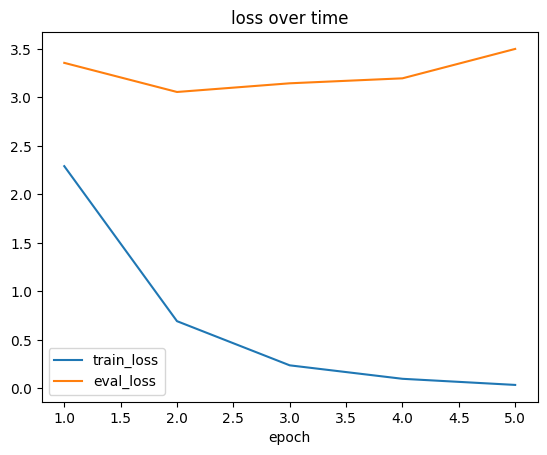

In [ ]:
train = trainer.state.log_history[:-1:2]
eval = trainer.state.log_history[1:-1:2]
train_loss = pd.DataFrame([epoch['loss'] for epoch in train], columns=['train_loss'])
train_loss['epoch'] = range(1, len(train_loss) + 1)
eval_loss = pd.DataFrame([[epoch['eval_loss'],epoch['eval_accuracy'],epoch['eval_f1'],epoch['eval_precision'],epoch['eval_recall']] for epoch in eval], columns=['eval_loss','eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall'])
eval_loss['epoch'] = range(1, len(eval_loss) + 1)
ax = train_loss.plot(x="epoch", y="train_loss")
eval_loss.plot(x="epoch", y="eval_loss", ax=ax)
plt.title("loss over time")
plt.show()

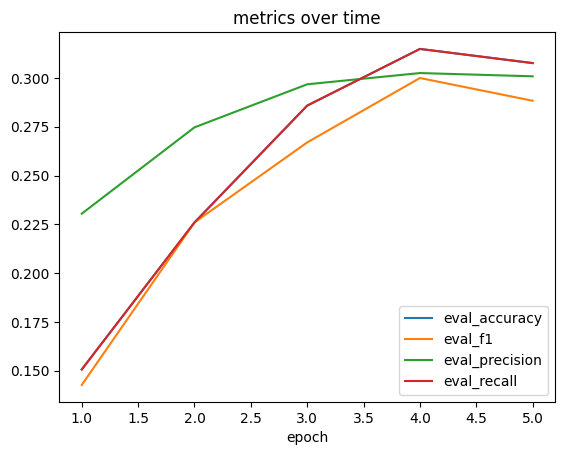

In [ ]:
ax2 = eval_loss.plot(x="epoch", y="eval_accuracy")
eval_loss.plot(x="epoch", y="eval_f1", ax=ax2)
eval_loss.plot(x="epoch", y="eval_precision", ax=ax2)
eval_loss.plot(x="epoch", y="eval_recall", ax=ax2)
plt.title("metrics over time")
plt.show()

# **Fine-tuning DistilBERT**

In [ ]:
model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

def tokenize(batch):
    return tokenizer(batch["lyrics"], padding=True, truncation=True, max_length=512)

In [ ]:
eval_df = pd.read_csv('/content/drive/MyDrive/CZ4034/eval_labeled_lyrics.csv')
len(eval_df), eval_df.columns

(1102,
 Index(['Unnamed: 0', 'artist', 'album', 'track', 'track_id', 'lyrics',
        'duration', 'genre', 'emotion', 'intensity'],
       dtype='object'))

In [ ]:
resampled_dataset = Dataset.from_pandas(resampled_df)
resampled_dataset

Dataset({
    features: ['lyrics', 'label', 'emotion'],
    num_rows: 4309
})

In [ ]:
eval_df["label"] = eval_df["emotion"].apply(lambda x: label2id[x])
eval_dataset = Dataset.from_pandas(eval_df)
eval_dataset

Dataset({
    features: ['Unnamed: 0', 'artist', 'album', 'track', 'track_id', 'lyrics', 'duration', 'genre', 'emotion', 'intensity', 'label'],
    num_rows: 1102
})

In [ ]:
resampled_encoded = resampled_dataset.map(tokenize, batched=True)
eval_encoded = eval_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/4309 [00:00<?, ? examples/s]

Map:   0%|          | 0/1102 [00:00<?, ? examples/s]

In [ ]:
resampled_encoded, eval_encoded

(Dataset({
     features: ['lyrics', 'label', 'emotion', 'input_ids', 'attention_mask'],
     num_rows: 4309
 }),
 Dataset({
     features: ['Unnamed: 0', 'artist', 'album', 'track', 'track_id', 'lyrics', 'duration', 'genre', 'emotion', 'intensity', 'label', 'input_ids', 'attention_mask'],
     num_rows: 1102
 }))

In [ ]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T


,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


In [ ]:
!huggingface-cli login --token HUGGINGFACE_TOKEN
# from huggingface_hub import notebook_login
# notebook_login()

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)
         .to(device))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
batch_size = 16
logging_steps = len(resampled_encoded) // batch_size
new_model = f"emotional-distilbert-3"
training_args = TrainingArguments(output_dir=new_model,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.0001,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  load_best_model_at_end=True,
                                  metric_for_best_model='eval_loss',
                                  greater_is_better=False,
                                  log_level="error")

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=resampled_encoded,
                  eval_dataset=eval_encoded,
                  tokenizer=tokenizer,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
                  )
trainer.train();


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.785700,2.706043,0.250454,0.230146,0.388143,0.250454
2,1.418300,2.166545,0.369328,0.367361,0.429526,0.369328
3,0.621000,1.869073,0.441924,0.434291,0.454497,0.441924
4,0.235200,1.840635,0.440109,0.433342,0.457142,0.440109
5,0.081600,1.989181,0.447368,0.433461,0.451756,0.447368
6,0.028400,2.108026,0.434664,0.422420,0.436509,0.434664
7,0.014100,2.151467,0.442831,0.425819,0.440750,0.442831


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

In [ ]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1712764770.c6325f312c89.1856.0:   0%|          | 0.00/11.0k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sherelyn912/emotional-distilbert-3/commit/964a3ceef91df0a2809cbeae04eb5540f57008ae', commit_message='End of training', commit_description='', oid='964a3ceef91df0a2809cbeae04eb5540f57008ae', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
for e in trainer.state.log_history:
    print(e.keys())

dict_keys(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step'])
dict_keys(['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])
dict_keys(['loss', 'grad_norm', 'learning_rate',

# **sherelyn912/emotional-distilbert-3** performance

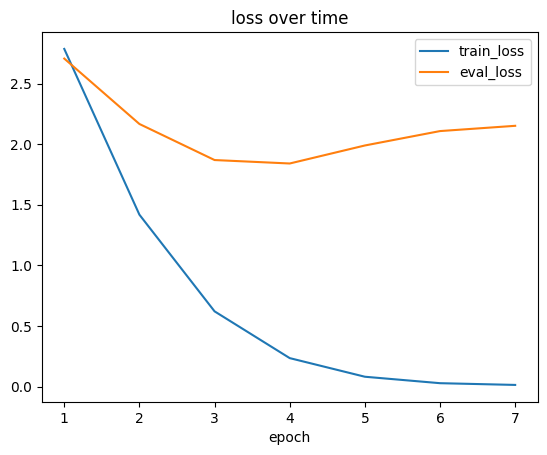

In [ ]:
train = trainer.state.log_history[:-1:2]
eval = trainer.state.log_history[1:-1:2]
train_loss = pd.DataFrame([epoch['loss'] for epoch in train], columns=['train_loss'])
train_loss['epoch'] = range(1, len(train_loss) + 1)
eval_loss = pd.DataFrame([[epoch['eval_loss'],epoch['eval_accuracy'],epoch['eval_f1'],epoch['eval_precision'],epoch['eval_recall']] for epoch in eval], columns=['eval_loss','eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall'])
eval_loss['epoch'] = range(1, len(eval_loss) + 1)
ax = train_loss.plot(x="epoch", y="train_loss")
eval_loss.plot(x="epoch", y="eval_loss", ax=ax)
plt.title("loss over time")
plt.show()

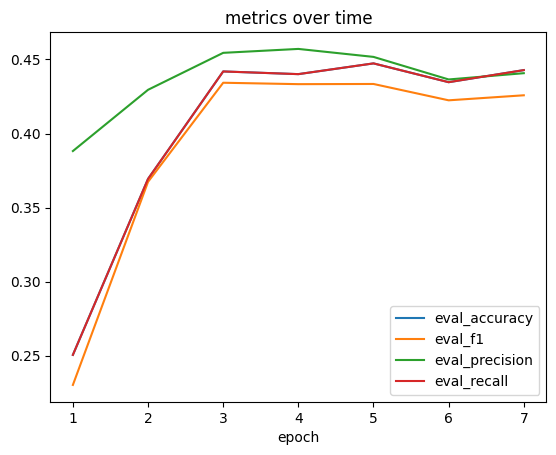

In [ ]:
ax2 = eval_loss.plot(x="epoch", y="eval_accuracy")
eval_loss.plot(x="epoch", y="eval_f1", ax=ax2)
eval_loss.plot(x="epoch", y="eval_precision", ax=ax2)
eval_loss.plot(x="epoch", y="eval_recall", ax=ax2)
plt.title("metrics over time")
plt.show()

# **ENSEMBLE CLASSIFICATION - XY VERSION**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = 32
id2label = {
    "0": "serenity",
    "1": "joy",
    "2": "ecstasy",
    "3": "love",
    "4": "acceptance",
    "5": "trust",
    "6": "admiration",
    "7": "submission",
    "8": "apprehension",
    "9": "fear",
    "10": "terror",
    "11": "awe",
    "12": "distraction",
    "13": "surprise",
    "14": "amazement",
    "15": "disapproval",
    "16": "pensiveness",
    "17": "sadness",
    "18": "grief",
    "19": "remorse",
    "20": "boredom",
    "21": "disgust",
    "22": "loathing",
    "23": "contempt",
    "24": "annoyance",
    "25": "anger",
    "26": "rage",
    "27": "aggressiveness",
    "28": "interest",
    "29": "anticipation",
    "30": "vigilance",
    "31": "optimism"

}

label2id = {
    "serenity": 0,
    "joy": 1,
    "ecstasy": 2,
    "love": 3,
    "acceptance": 4,
    "trust": 5,
    "admiration": 6,
    "submission": 7,
    "apprehension": 8,
    "fear": 9,
    "terror": 10,
    "awe": 11,
    "distraction": 12,
    "surprise": 13,
    "amazement": 14,
    "disapproval": 15,
    "pensiveness": 16,
    "sadness": 17,
    "grief": 18,
    "remorse": 19,
    "boredom": 20,
    "disgust": 21,
    "loathing": 22,
    "contempt": 23,
    "annoyance": 24,
    "anger": 25,
    "rage": 26,
    "aggressiveness": 27,
    "interest": 28,
    "anticipation": 29,
    "vigilance": 30,
    "optimism": 31
}


In [ ]:
eval_df = pd.read_csv('/content/drive/MyDrive/CZ4034/eval_labeled_lyrics.csv')
len(eval_df), eval_df.columns

(1102,
 Index(['Unnamed: 0', 'artist', 'album', 'track', 'track_id', 'lyrics',
        'duration', 'genre', 'emotion', 'intensity'],
       dtype='object'))

In [ ]:
eval_df["label"] = eval_df["emotion"].apply(lambda x: label2id[x])
eval_dataset = Dataset.from_pandas(eval_df)
eval_dataset

Dataset({
    features: ['Unnamed: 0', 'artist', 'album', 'track', 'track_id', 'lyrics', 'duration', 'genre', 'emotion', 'intensity', 'label'],
    num_rows: 1102
})

In [ ]:
def tokenize(batch):
    return tokenizer(batch["lyrics"], padding=True, truncation=True, max_length=512)

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
eval_distilbert = eval_dataset.map(tokenize, batched=True)

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
eval_gpt2 = eval_dataset.map(tokenize, batched=True)

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
eval_bert = eval_dataset.map(tokenize, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1102 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/1102 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1102 [00:00<?, ? examples/s]

In [ ]:
eval_distilbert = eval_distilbert.with_format("torch")
eval_gpt2 = eval_gpt2.with_format("torch")
eval_bert = eval_bert.with_format("torch")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader

# Create the individual models
distilbert_model = (AutoModelForSequenceClassification.from_pretrained("sherelyn912/emotional-distilbert-3", num_labels=num_labels, id2label=id2label, label2id=label2id).to(device))
gpt2_model = (AutoModelForSequenceClassification.from_pretrained("sherelyn912/emotional-gpt2", num_labels=num_labels, id2label=id2label, label2id=label2id).to(device))
bert_model = (AutoModelForSequenceClassification.from_pretrained("sherelyn912/emotional-bert", num_labels=num_labels, id2label=id2label, label2id=label2id).to(device))
gpt2_model.config.pad_token_id = gpt2_model.config.eos_token_id

# Create a DataLoader for your validation dataset
distilbert_dataloader = DataLoader(eval_distilbert, batch_size=16)
gpt2_dataloader = DataLoader(eval_gpt2, batch_size=16)
bert_dataloader = DataLoader(eval_bert, batch_size=16)

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

# **WEIGHTED AVERAGING**

In [ ]:
# Calculate weights based on accuracies
accuracy_distilbert = 0.44010889
accuracy_gpt2 = 0.225953
accuracy_bert = 0.376588
total_accuracy = accuracy_distilbert + accuracy_gpt2 + accuracy_bert
weight_distilbert = accuracy_distilbert / total_accuracy
weight_gpt2 = accuracy_gpt2 / total_accuracy
weight_bert = accuracy_bert / total_accuracy

# MODEL 1
all_preds = []
for batch in distilbert_dataloader:
    inputs = {'input_ids': batch['input_ids'].to(device), 'attention_mask': batch['attention_mask'].to(device)}
    with torch.no_grad():
        outputs = distilbert_model(**inputs)
    logits = outputs.logits
    all_preds.append(logits)
preds = torch.cat(all_preds, dim=0)
total_preds = preds*weight_distilbert

# MODEL 2
all_preds = []
for batch in gpt2_dataloader:
    inputs = {'input_ids': batch['input_ids'].to(device), 'attention_mask': batch['attention_mask'].to(device)}
    with torch.no_grad():
        outputs = gpt2_model(**inputs)
    logits = outputs.logits
    all_preds.append(logits)
preds = torch.cat(all_preds, dim=0)
total_preds += preds*weight_gpt2

# MODEL 3
all_preds = []
for batch in bert_dataloader:
    inputs = {'input_ids': batch['input_ids'].to(device), 'attention_mask': batch['attention_mask'].to(device)}
    with torch.no_grad():
        outputs = bert_model(**inputs)
    logits = outputs.logits
    all_preds.append(logits)
preds = torch.cat(all_preds, dim=0)
total_preds += preds*weight_bert

# Convert predictions to labels
predicted_labels = torch.argmax(total_preds, dim=1)
predicted_labels

tensor([ 1,  1,  1,  ...,  3,  3, 31], device='cuda:0')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

true_labels = []
for batch in distilbert_dataloader:
    true_labels+=batch['label']

predicted_labels = predicted_labels.cpu()
true_labels = torch.Tensor(true_labels)
f1 = f1_score(true_labels, predicted_labels, average="weighted")
acc = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

print({"accuracy": acc, "f1": f1, "precision": precision, "recall": recall})

{'accuracy': 0.44101633393829404, 'f1': 0.43219885356466503, 'precision': 0.4462152526554985, 'recall': 0.44101633393829404}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
